<a href="https://colab.research.google.com/github/kaleem500bc/SingleObjectLocalization/blob/master/SingleObjectLocalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import models, transforms
from matplotlib import pyplot as plt
from pycocotools.coco import COCO
import cv2
from skimage import io
from matplotlib import patches
import os
from PIL import Image
plt.ion()

Github project https://github.com/ckczzj/Image-Object-Localization

In [ ]:
!wget https://github.com/ckczzj/Image-Object-Localization/archive/master.zip
!unzip master.zip

In [ ]:
#data preprocess

bboxPath = '/content/Image-Object-Localization-master/src/data/bounding_boxes.txt'
bboxfile = open(bboxPath)
bboxes = bboxfile.read()
bboxes = bboxes.split('\n')
bboxesfloat = [float(j) for i in bboxes for j in i.split()[1:]]
bboxes = [bboxesfloat[i:i+4] for i in range(0,len(bboxesfloat),4)]

imgsPath = '/content/Image-Object-Localization-master/src/data/images.txt'
imgsPath = open(imgsPath)
imgsPath = imgsPath.read()
imgsPath = imgsPath.split('\n')
imgsPath = ' '.join(imgsPath).split(' ')
imgsPath = imgsPath[1::2]
rootImgs = '/content/Image-Object-Localization-master/src/data/images/'
imgsPath = [rootImgs+i for i in imgsPath]



500
385


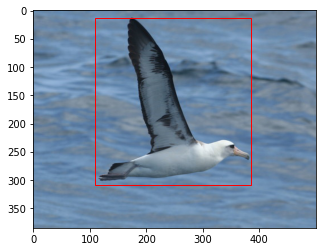

In [ ]:
#Display 1 image with label
ithImage = 81
img = os.path.join(rootImgs,imgsPath[ithImage])
img = Image.open(img)
print(width)
print(height)
plt.imshow(img)
ax = plt.gca()
rect = patches.Rectangle((bboxes[ithImage][0],bboxes[ithImage][1]),bboxes[ithImage][2],bboxes[ithImage][3], color='red',fill=False)
ax.add_patch(rect)

In [ ]:
#Custom dataset
class customDataset(torch.utils.data.Dataset):
  def __init__(self,imgsPath,labels, transform = None):
    self.imgsList = imgsPath
    self.labels = labels
    self.transform = transform

  def __getitem__(self, imgIdx):
    img = Image.open(self.imgsList[imgIdx]).convert('RGB')
    width, height = img.size
    label = torch.tensor(self.labels[imgIdx])
    label[0] = label[0]/width
    label[1] = label[1]/height
    label[2] = label[2]/width
    label[3] = label[3]/height



    if self.transform is not None:
      img = self.transform(img)

    


    return img, label
  
  def __len__(self):
    return len(self.imgsList)








In [ ]:
#Download and use inception model 
model_inception =  models.inception_v3(pretrained=True, aux_logits=False)
numFeatures = model_inception.fc.in_features

#freeze all the layers of the model
for parameter in model_inception.parameters():
  parameter.requires_grade = False






In [ ]:
#attach our own head to the fc, which output the bounding box' values
model_inception.fc = nn.Sequential(
    nn.Linear(numFeatures, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128,4)
)

In [ ]:
#initialize weights of the attached layers 
for layers in model_inception.fc:
  if type(layers) == nn.Linear:
    torch.nn.init.xavier_normal_(layers.weight.data)

In [ ]:
transform = torchvision.transforms.Compose([
                    #As input to inception model 3x299x299
                    torchvision.transforms.Resize((299,299)),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#imgsPath is the path to the root of the images, bboxes is the path to the root of the label/bounding boxes
dataset = customDataset(imgsPath,bboxes,transform)

#split data into test and training set
testSize = 0.3

datasetSize = len(dataset)

indices = list(range(datasetSize))

split = int(datasetSize * testSize)

#test set indices
testIndices = indices[:split]

#training set indices
trainIndices = indices[split:]

BatchSize = 32

trainLoader = torch.utils.data.DataLoader(dataset,batch_size = BatchSize, sampler=trainIndices)

testLoader = torch.utils.data.DataLoader(dataset, batch_size = BatchSize, sampler=testIndices)

#use smoothL1Loss as it is more robust then MSE loss
criterion = nn.SmoothL1Loss()

optim = torch.optim.Adam(model_inception.parameters())


In [ ]:
model_inception.to("cuda")

def train(epoch):

  trainloss = []
  testloss = []

  for e in range(epoch):
    print("epoch : " + str(e+1))
    model_inception.train()
    trainloss.append(0)
    testloss.append(0)

    for img, label in trainLoader:
      img,label = img.to("cuda"), label.to("cuda")
      out = model_inception(img)
      optim.zero_grad()
      loss = criterion(out,label)
      loss.backward()
      optim.step()
      trainloss[e] = trainloss[e] + loss.item()
    print("training loss: " + str(trainloss[e]))

    model_inception.eval()
    for img, label in testLoader:
      img,label = img.to("cuda"), label.to("cuda")
      out = model_inception(img)
      loss = criterion(out,label)
      loss.backward()
      testloss[e] = testloss[e] + loss.item()

    print("test loss: " + str(testloss[e]))
  return trainloss,testloss

      
    


In [ ]:
epoch = 5
trainloss,testloss = train(epoch)

epoch : 1
training loss: 2.495084354188293
test loss: 0.9389627203345299
epoch : 2
training loss: 1.8647234956733882
test loss: 0.7942750426009297
epoch : 3
training loss: 1.4833125036675483
test loss: 0.6340268687345088
epoch : 4
training loss: 1.2296286129858345
test loss: 0.5414460855536163
epoch : 5
training loss: 1.224684968125075
test loss: 0.5703430948778987


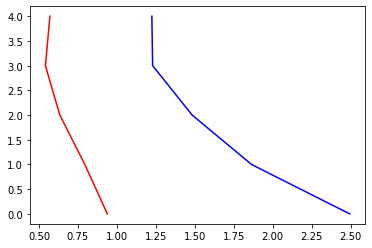

In [ ]:
epochs4Plot = list(range(epoch))
plt.plot(trainloss,epochs4Plot,'blue')
plt.plot(testloss,epochs4Plot,'red')

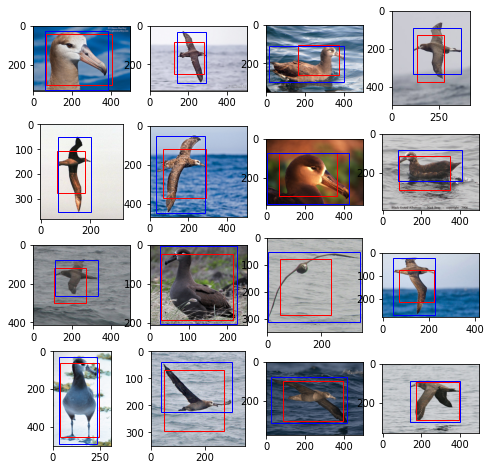

In [ ]:
#test model on test set

imgGrid = 4 # imgGrid x imgGrid, images' grid

#set model to eval mode
model_inception.eval()

fig = plt.figure(figsize=(8,8))
for idx in range(imgGrid**2):

  idx = int(idx * split // split)
  image = Image.open(imgsPath[idx])
  img = transform(image).unsqueeze(0).to("cuda")
  out = model_inception(img)[0]
  width, height = image.size
  bbx = bboxes[idx]
  fig.add_subplot(imgGrid,imgGrid,idx+1)
  plt.imshow(image)
  ax = plt.gca()
  rectr = patches.Rectangle((out[0]*width,out[1]*height),out[2]*width,out[3]*height, color = 'red', fill=False)
  rectb = patches.Rectangle((bbx[0],bbx[1]),bbx[2],bbx[3], color = 'blue', fill=False)
  ax.add_patch(rectr)
  ax.add_patch(rectb)

plt.show()


--2020-09-06 16:35:56--  https://drivetribe.imgix.net/Qjw4y3suTUe5iKhTpA6ulA
Resolving drivetribe.imgix.net (drivetribe.imgix.net)... 151.101.78.208, 2a04:4e42:12::720
Connecting to drivetribe.imgix.net (drivetribe.imgix.net)|151.101.78.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167150 (163K) [image/jpeg]
Saving to: ‘t’

t                   100%[===================>] 163.23K  --.-KB/s    in 0.04s   

2020-09-06 16:35:56 (3.65 MB/s) - ‘t’ saved [167150/167150]



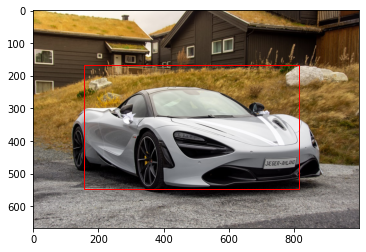

In [ ]:


!wget --output-document t https://drivetribe.imgix.net/Qjw4y3suTUe5iKhTpA6ulA
testImg = Image.open('t')
testImg = transform(testImg)
testImg = testImg.to("cuda")
testImg = testImg.unsqueeze(0)
model_inception.eval()
out = model_inception(testImg)
out2 = out[0]
out2
img = Image.open('t')
width, height = img.size
plt.imshow(img)
ax = plt.gca()
rect = patches.Rectangle((out2[0]*width,out2[1]*height),out2[2]*width,out2[3]*height, color = 'red', fill=False)
ax.add_patch(rect)